# Example: PyRayHF Spherical Snell’s Law Raytracing

### Background: Snell’s Law in a Plasma

In a uniform dielectric, Snell’s law states that  

$$
n \cdot \sin(\theta) = \text{constant},
$$  

where *n* is the refractive index and *θ* is the propagation angle relative to the vertical.  

In a plasma, however, the refractive index is not constant. It depends on:  

- **Electron density** → determines the plasma frequency  
- **Magnetic field strength** → splits propagation into ordinary and extraordinary modes  
- **Radio frequency** of the transmitted wave  
- **Angle** between the wave vector and the geomagnetic field  

This results in two possible propagation modes:  

- **Ordinary (O) mode**  
- **Extraordinary (X) mode**  

In PyRayHF, the helper functions `find_X`, `find_Y`, and `find_mu_mup` compute these indices as functions of altitude.  

Thus, the plasma-modified Snell’s law is applied as  

$$
\mu \cdot \sin(\theta) = \text{constant},
$$  

where *μ* is the **phase refractive index** for the chosen wave mode.  

Once the geometric path is determined, the **group delay** is evaluated by integrating along the trajectory using the **group refractive index** *μ′*.  

---

### Specifics in PyRayHF (Spherical Formulation)

- Geometry (bending) uses the **phase index μ** in spherical geometry  
- The Snell invariant is enforced as  
  $$
  \mu \cdot r \cdot \sin(\theta) = \text{constant},
  $$
  where *r* is the radial distance from the Earth’s center
- Group delay integrates the **group index μ′** (mup) along the curved trajectory
- The down-leg is constructed as a **mirror of the up-leg** about the turning point (apex) 
- Outputs include both spherical coordinates (central angle ψ, altitude z) and Cartesian-like coordinates (x, z) for plotting convenience

---

### Notes on Visualization

- **Flat view**: x-axis = ground arc length [km], y-axis = altitude above Earth’s surface [km]



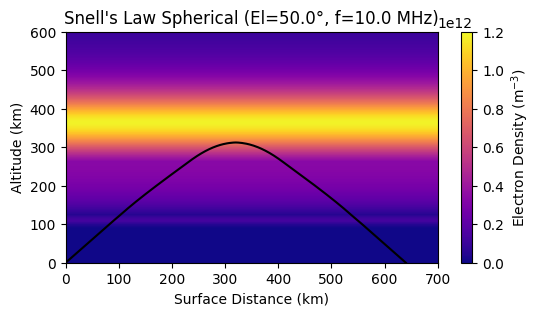

--------------------------------------------------
Spherical Snell's Law Raytracing:
--------------------------------------------------
Group Path (km):  908.568361604233
Group delay (sec):  0.0034587029649713226
Ground Range (km):  640.1867550395866
x midpoint (km):  320.0933775197933
z midpoint (km):  312.28223436121976


In [1]:
#!/usr/bin/env python
import numpy as np
import pickle
import matplotlib.pyplot as plt
from PyRayHF.library import trace_ray_spherical_snells

# Load an ionospheric profile
# See Example_Generate_Input_Arrays for how to create input
# arrays using PyIRI.
file_open = 'Example_input.p'
input_arrays = pickle.load(open(file_open, 'rb'))

alt_km = input_arrays["alt"]
Ne = input_arrays["den"]
Babs = input_arrays["bmag"]
bpsi = input_arrays["bpsi"]

# Ensure ground level is included
h_ground = 0
if alt_km[0] > h_ground:
    Ne0 = np.interp(h_ground, alt_km, Ne)
    Babs0 = np.interp(h_ground, alt_km, Babs)
    bpsi0 = np.interp(h_ground, alt_km, bpsi)
    alt_km = np.insert(alt_km, 0, h_ground)
    Ne = np.insert(Ne, 0, Ne0)
    Babs = np.insert(Babs, 0, Babs0)
    bpsi = np.insert(bpsi, 0, bpsi0)

# Define inputs
elevation_deg = 50.
f0_Hz = 10e6
mode = "O"

# Trace Using Snell's Law Spherical 2-D Raytracing
result = trace_ray_spherical_snells(f0_Hz=f0_Hz,
                                    elevation_deg=elevation_deg,
                                    alt_km=alt_km,
                                    Ne=Ne,
                                    Babs=Babs,
                                    bpsi=bpsi,
                                    mode=mode)

# Plot the results.
# Create 2D density grid (Ne assumed horizontally uniform)
nx = 500
xmax = np.max(result['x']) * 1.1
x_grid = np.linspace(0, xmax, nx)
z_grid = alt_km
Xg, Zg = np.meshgrid(x_grid, z_grid)
Ne_grid = np.tile(Ne[:, np.newaxis], (1, nx))

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 3)
ax_plot = ax
ax_plot.set_xlim(0, 700)
ax_plot.set_ylim(0, 600)
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Altitude (km)')
ax_plot.set_xlabel('Surface Distance (km)')
vmin = 0
vmax = 1.2e12
color_ticks = np.arange(vmin, vmax + 2e11, 2e11)
pc = ax_plot.pcolormesh(Xg, Zg, Ne_grid, shading='auto',
                        cmap='plasma', vmin=vmin, vmax=vmax)
ax_plot.plot(result['x'], result['z'], c='black')
ax_plot.set_title(f"Snell\'s Law Spherical (El={elevation_deg:.1f}°, f={f0_Hz/1e6} MHz)")
plt.colorbar(pc, label='Electron Density (m$^{-3}$)', ax=ax_plot,
             ticks=color_ticks)
plt.savefig('/Users/vmakarevich/Documents/GitHub/PyRayHF/docs/examples/figures/Spherical_Snells_Law.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print('--------------------------------------------------')
print('Spherical Snell\'s Law Raytracing:')
print('--------------------------------------------------')
print('Group Path (km): ', result['group_path_km'])
print('Group delay (sec): ', result['group_delay_sec'])
print('Ground Range (km): ', result['ground_range_km'])
print('x midpoint (km): ', result['x_midpoint'])
print('z midpoint (km): ', result['z_midpoint'])